# Binary Classification of Spectrograms #

The Aretas platform has the ability to ingest acoustic and vibration data from thousands of Aretas IoT monitors deployed in various customer applications. 

We can classify the data  in the platform and generate spectrograms from the data packets and export the labeled spectrograms for model training and deployment. The spectrograms in the platform can support:
- Overlapping
- Arbitrary sample rates
- Interpolation 
- Resizing
- Multiple pallettes

For this experiment, we produced low-sample rate data of different individuals saying "cat" or "dog" and produced confounder test data of different words that sounds like "cat" (sand, ae, family, etc.) All test, training and validation data was specifically downsampled to 8kHz (16-bit) for more challenging classification. 


In [1]:
from fastai.vision.all import *

In [2]:
image_data_path = Path("Y:/ai-audio-images/spectrograms")

In [3]:
image_data_path.ls()

(#3) [Path('Y:/ai-audio-images/spectrograms/cat'),Path('Y:/ai-audio-images/spectrograms/dog'),Path('Y:/ai-audio-images/spectrograms/models')]

In [4]:
files = get_image_files(image_data_path)

In [5]:
len(files)

38

In [6]:
files[0]

Path('Y:/ai-audio-images/spectrograms/cat/Spectrogram-sample-cat-1667112267878.png')

In [7]:
files[0].parts[3]

'cat'

Label function to extract the label from the path

In [ ]:
def label_func(f):
    # print(f)
    label = f.parts[3]
    return label


In [9]:
dls = ImageDataLoaders.from_path_func(image_data_path, files, label_func, valid_pct=0.2, bs=8, item_tfms=Resize((60,130), ResizeMethod.Squish))

Due to IPython and Windows limitation, python multiprocessing isn't available now.
So `number_workers` is changed to 0 to avoid getting stuck


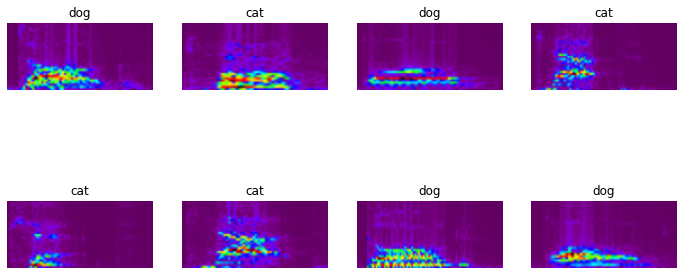

In [10]:
dls.show_batch()

SuggestedLRs(valley=0.0010000000474974513)

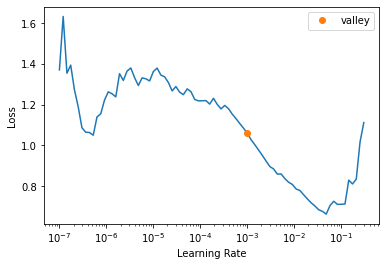

In [30]:
learn = vision_learner(dls, resnet34, metrics=error_rate)
learn.lr_find(num_it=100)

In [31]:
lr = 10e-3
learn.fit_one_cycle(1, slice(lr))

epoch,train_loss,valid_loss,error_rate,time
0,1.394214,1.596265,0.428571,00:00


In [32]:
learn.unfreeze()
learn.fit_one_cycle(10)

epoch,train_loss,valid_loss,error_rate,time
0,0.661021,0.499155,0.428571,00:00
1,0.505490,1.454977,0.285714,00:00
2,0.464360,2.001259,0.428571,00:00
3,0.647887,0.418917,0.142857,00:00
4,0.571979,8.083179,0.285714,00:00
5,0.471201,9.252481,0.285714,00:00
6,0.391228,6.142246,0.285714,00:00
7,0.430513,2.706112,0.285714,00:00
8,0.410444,0.001342,0.000000,00:00
9,0.359734,0.000039,0.000000,00:00


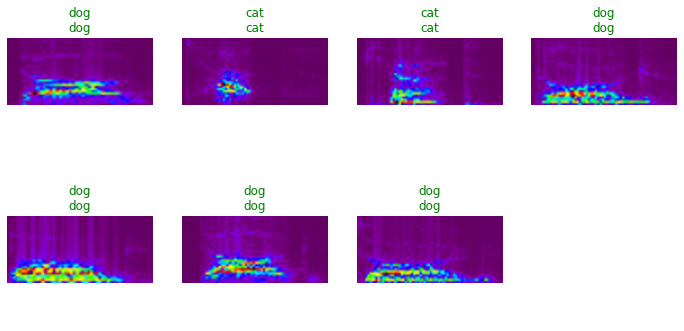

In [33]:
learn.show_results()

In [34]:
interp = Interpretation.from_learner(learn)

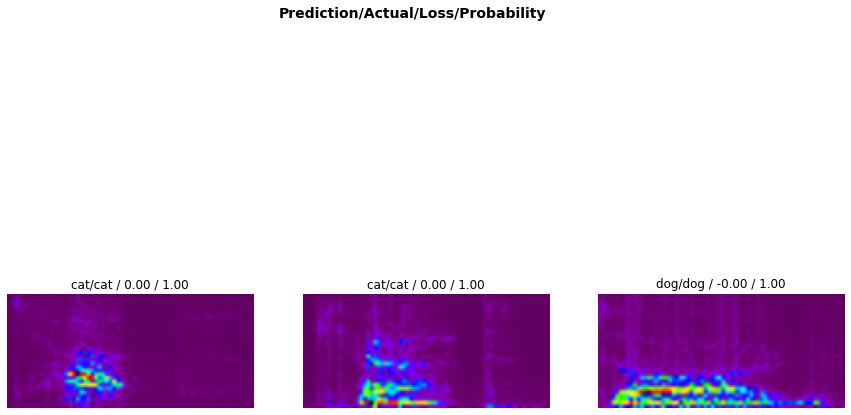

In [35]:
interp.plot_top_losses(3, figsize=(15,10))

## Testing on previously unseen images and confounders ##
We have completely held back a test set using different voices from different people saying 'cat' and other 'ae' sounds for confounders. Note that there are no 'dog' sounds in the dataset. 

We will establish an xx% probability threshold for our confidence that a sound is 'cat' (will depend on the model accuracy we observe)

In [36]:
test_set_path = Path("Y:/ai-test-audio-images/spectrograms/")
test_set_images = get_image_files(test_set_path)
test_set_images

(#10) [Path('Y:/ai-test-audio-images/spectrograms/ae/Spectrogram-sample-ae-1667166559972.png'),Path('Y:/ai-test-audio-images/spectrograms/ae/Spectrogram-sample-ae-1667166560062.png'),Path('Y:/ai-test-audio-images/spectrograms/back/Spectrogram-sample-back-1667166560116.png'),Path('Y:/ai-test-audio-images/spectrograms/cat/Spectrogram-sample-cat-1667166560166.png'),Path('Y:/ai-test-audio-images/spectrograms/cat/Spectrogram-sample-cat-1667166560257.png'),Path('Y:/ai-test-audio-images/spectrograms/family/Spectrogram-sample-family-1667166560327.png'),Path('Y:/ai-test-audio-images/spectrograms/ran/Spectrogram-sample-ran-1667166560759.png'),Path('Y:/ai-test-audio-images/spectrograms/sand/Spectrogram-sample-sand-1667166562092.png'),Path('Y:/ai-test-audio-images/spectrograms/sand/Spectrogram-sample-sand-1667166562111.png'),Path('Y:/ai-test-audio-images/spectrograms/that/Spectrogram-sample-that-1667166562131.png')]

In [46]:
accuracy = [[0.0,0.0],[0.0,0.0]]
for i in test_set_images:
    actual = i.parts[3]
    print("---------------------------------")
    print("Actual:" + actual)
    result = learn.predict(i)
    print("Prediction:" + result[0])
    target_prob = result[2][0];
    print(float(target_prob))
    print(result)
    print("---------------------------------")
    print('\n')
    threshold = 0.8
    
    # true positive
    if(actual == 'cat' and target_prob >= threshold):
        accuracy[0][0] = accuracy[0][0] + 1.0
    
    # false negative
    if(actual == 'cat' and target_prob < threshold):
        accuracy[1][0] = accuracy[1][0] + 1.0
        
    #false positive
    if(actual != 'cat' and target_prob >= threshold):
        accuracy[0][1] = accuracy[0][1] + 1.0
        
    #true negative
    if(actual != 'cat' and target_prob < threshold):
        accuracy[1][1] = accuracy[1][1] + 1.0

        
        

---------------------------------
Actual:ae


Prediction:dog
4.469602117751492e-06
('dog', TensorBase(1), TensorBase([4.4696e-06, 1.0000e+00]))
---------------------------------


---------------------------------
Actual:ae


Prediction:dog
4.6937209845054895e-05
('dog', TensorBase(1), TensorBase([4.6937e-05, 9.9995e-01]))
---------------------------------


---------------------------------
Actual:back


Prediction:dog
3.560205368557945e-05
('dog', TensorBase(1), TensorBase([3.5602e-05, 9.9996e-01]))
---------------------------------


---------------------------------
Actual:cat


Prediction:cat
0.9999734163284302
('cat', TensorBase(0), TensorBase([9.9997e-01, 2.6575e-05]))
---------------------------------


---------------------------------
Actual:cat


Prediction:cat
0.999987006187439
('cat', TensorBase(0), TensorBase([9.9999e-01, 1.2938e-05]))
---------------------------------


---------------------------------
Actual:family


Prediction:dog
1.92445382546369e-11
('dog', TensorBase(1), TensorBase([1.9245e-11, 1.0000e+00]))
---------------------------------


---------------------------------
Actual:ran


Prediction:dog
0.11995618045330048
('dog', TensorBase(1), TensorBase([0.1200, 0.8800]))
---------------------------------


---------------------------------
Actual:sand


Prediction:dog
4.922901197801366e-09
('dog', TensorBase(1), TensorBase([4.9229e-09, 1.0000e+00]))
---------------------------------


---------------------------------
Actual:sand


Prediction:dog
1.520037096192084e-09
('dog', TensorBase(1), TensorBase([1.5200e-09, 1.0000e+00]))
---------------------------------


---------------------------------
Actual:that


Prediction:dog
1.0838296926607427e-09
('dog', TensorBase(1), TensorBase([1.0838e-09, 1.0000e+00]))
---------------------------------




,0,1
0,2.0,0.0
1,0.0,8.0


Confusion matrix

In [47]:
from IPython.display import display, HTML
display(HTML(pd.DataFrame(accuracy).to_html()))

,0,1
0,2.0,0.0
1,0.0,8.0


In [38]:
# export FastAI learner
# learn.export('best_model.pkl')
# load FastAI learner
# learn = load_learner('model.pkl')
# img = PILImage.create('test_images/blah.jpg')
# img.to_thumb(192)